## Practical 2: Controllable (Image) Generation

In this notebook, we will apply our knowledge from the first to image generation.


### Setup

---

Additional Notes and Setup (framework info, python imports etc)


In [ ]:
!wget https://huggingface.co/Gabrijel/m2l-diffusion/resolve/main/cond.pth
!wget https://huggingface.co/Gabrijel/m2l-diffusion/resolve/main/uncond.pth

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


import torch
import torch.nn as nn
import math
from typing import Tuple, Union
from einops import rearrange
from einops.layers.torch import Rearrange
from typing import Optional

import torch.nn as nn

import math


class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """

    def __init__(self, model_dim: int, patch_size: int, out_channels: int) -> None:
        super().__init__()
        self.norm = nn.LayerNorm(
            model_dim,
            elementwise_affine=False,
            eps=1e-6
        )
        self.proj = nn.Linear(
            model_dim,
            patch_size * patch_size * out_channels,
            bias=True
        )
        self.adaptive_norm_params = nn.Sequential(
            nn.SiLU(),
            nn.Linear(model_dim, 2 * model_dim, bias=True)
        )

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        shift, scale = self.adaptive_norm_params(c).chunk(2, dim=1)
        x = modulate(self.norm(x), shift, scale)
        x = self.proj(x)
        return x


class PatchEmbed(nn.Module):
    def __init__(
        self,
        input_size: Tuple[int, int],
        patch_size: Union[int, Tuple[int, int]],
        in_channels: int,
        model_dim: int,
    ) -> None:
        """
        Args:
            input_size: (height, width) of the input image.
            patch_size: Size of each patch (Ph, Pw) or single int for square patches.
            in_channels: Number of input channels (e.g., 3 for RGB).
            model_dim: Dimension of the patch embedding (model_dim).
        """
        super().__init__()

        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)

        self.patch_size: Tuple[int, int] = patch_size
        self.input_size: Tuple[int, int] = input_size

        self.proj: nn.Conv2d = nn.Conv2d(
            in_channels,
            model_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.num_patches: int = (
            (input_size[0] // patch_size[0]) *
            (input_size[1] // patch_size[1])
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (B, C, H, W)
        Returns:
            Patch embeddings of shape (B, N_patches, model_dim)
        """
        x = self.proj(x)  # (B, model_dim, H', W')
        x = rearrange(
            x,
            'b c h w -> b (h w) c'
        )  # (B, N_patches, model_dim)
        return x


class Unpatchify(Rearrange):
    def __init__(
        self,
        num_patches: int,
        patch_size: int,
        out_channels: int
    ):
        h = w = int(math.sqrt(num_patches))
        super(Unpatchify, self).__init__(
            'n (h w) (p1 p2 c) -> n c (h p1) (w p2)',
            h=h,
            w=w,
            p1=patch_size,
            p2=patch_size,
            c=out_channels
        )


class Mlp(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        hidden_features: Optional[int] = None,
        out_features: Optional[int] = None,
    ) -> None:
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features

        super().__init__(
            nn.Linear(in_features, hidden_features, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_features, out_features, bias=True)
        )


#################################################################################
#                   Sine/Cosine Positional Embedding Functions                  #
#################################################################################
# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py


def get_2d_sincos_pos_embed(
    embed_dim: int,
    grid_size: int,
    cls_token: bool = False,
    extra_tokens: int = 0
) -> np.ndarray:
    """
    :param embed_dim: Dimension of the positional embedding
    :param grid_size: Height and width of the grid
    :param cls_token: Whether to prepend extra tokens (e.g., [CLS])
    :param extra_tokens: Number of extra tokens to prepend
    :return: Positional embedding of shape [(extra_tokens + grid_size^2), embed_dim]
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    # shape: (2, grid_size, grid_size)
    grid = np.meshgrid(grid_w, grid_h)
    grid = np.stack(grid, axis=0)  # shape: (2, grid_size, grid_size)
    grid = grid.reshape([2, 1, grid_size, grid_size])

    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)

    if cls_token and extra_tokens > 0:
        extra = np.zeros(
            [extra_tokens, embed_dim],
            dtype=np.float32
        )
        pos_embed = np.concatenate(
            [extra, pos_embed],
            axis=0
        )

    return pos_embed


def get_2d_sincos_pos_embed_from_grid(
    embed_dim: int,
    grid: np.ndarray
) -> np.ndarray:
    """
    :param embed_dim: Total embedding dimension (must be even)
    :param grid: Array of shape (2, 1, grid_size, grid_size)
    :return: Positional embedding of shape [grid_size^2, embed_dim]
    """
    assert embed_dim % 2 == 0, "Embedding dimension must be even"
    emb_h = get_1d_sincos_pos_embed_from_grid(
        embed_dim // 2,
        grid[0]
    )
    emb_w = get_1d_sincos_pos_embed_from_grid(
        embed_dim // 2,
        grid[1]
    )
    return np.concatenate(
        [emb_h, emb_w],
        axis=1
    )


def get_1d_sincos_pos_embed_from_grid(
    embed_dim: int,
    pos: np.ndarray
) -> np.ndarray:
    """
    :param embed_dim: Output embedding dimension for each position (must be even)
    :param pos: 1D array of positions to be encoded, shape (M,)
    :return: Positional encoding of shape (M, embed_dim)
    """
    assert embed_dim % 2 == 0, "Embedding dimension must be even"

    omega: np.ndarray = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / (10000**omega)  # shape: (D/2,)

    pos = pos.reshape(-1)  # shape: (M,)
    out = np.einsum('m,d->md', pos, omega)  # shape: (M, D/2)

    return np.concatenate(
        [np.sin(out), np.cos(out)],
        axis=1
    )  # shape: (M, D)


#################################################################################
#               Embedding Layers for Timesteps and Class Labels                 #
#################################################################################

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """

    def __init__(self, model_dim: int, frequency_embedding_size: int = 256) -> None:
        super().__init__()
        self.mlp = Mlp(
            frequency_embedding_size,
            model_dim,
            model_dim
        )
        self.frequency_embedding_size: int = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t: torch.Tensor, dim: int, max_period: int = 10000) -> torch.Tensor:
        """
        Create sinusoidal timestep embeddings.

        :param t: a 1-D torch.Tensor of N indices, one per batch element. These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) torch.Tensor of positional embeddings.
        """
        half: int = dim // 2
        freqs: torch.Tensor = torch.exp(
            -math.log(max_period) * torch.arange(
                start=0,
                end=half,
                dtype=torch.float32
            ) / half
        ).to(device=t.device)
        args: torch.Tensor = t[:, None].float() * freqs[None]
        embedding = torch.cat(
            [torch.cos(args), torch.sin(args)],
            dim=-1
        )
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        return self.mlp(
            self.timestep_embedding(t, self.frequency_embedding_size)
        )


def modulate(x: torch.Tensor, shift: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    # todo: Add shape annotations
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

In [ ]:
import torch


def beta(t, beta_min=0.1, beta_max=20):
    """
    Linear beta schedule for VP-SDE.

    Args:
        t: torch.Tensor of shape (...), values in [0,1]
        beta_min: minimum beta
        beta_max: maximum beta

    Returns:
        beta(t): torch.Tensor of same shape as t
    """
    return beta_min + t * (beta_max - beta_min)


def alpha(t, beta_min=0.1, beta_max=20):
    """
    Compute alpha(t) for VP-SDE with linear beta schedule.

    Args:
        t: torch.Tensor of shape (...), values in [0,1]

    Returns:
        alpha: torch.Tensor same shape as t
    """
    integral = beta_min * t + 0.5 * (beta_max - beta_min) * t**2
    return torch.exp(-0.5 * integral)


def sigma(t, beta_min=0.1, beta_max=20):
    """
    Compute sigma(t) for VP-SDE with linear beta schedule.

    Args:
        t: torch.Tensor of shape (...), values in [0,1]

    Returns:
        sigma: torch.Tensor same shape as t
    """
    return torch.sqrt(1 - torch.square(alpha(t, beta_min, beta_max)))

In [ ]:
from typing import Tuple
from einops import rearrange
import torch


@torch.inference_mode()
def sample_vp_sde_euler_maruyama_unconditional(
    model,
    num_samples,
    T=1.0,
    num_steps=1000,
    eps=1e-5,
    device='cpu',
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Create time steps from T down to eps, for numerical stability
    t_steps = torch.linspace(T, eps, num_steps + 1, device=device)
    # Start with a random noise vector for all samples
    x = torch.randn((num_samples, 1, 28, 28), device=device)
    # List to store the trajectory of each sample
    trajectory = [x.clone()]
    for i in range(num_steps):
        t = t_steps[i]
        # Differentials
        dt = t_steps[i] - t_steps[i+1]  # positive
        dw = torch.randn_like(x)
        # Create a time tensor for the batch, now with shape (num_samples,)
        t_batch = torch.full((num_samples,), t, device=device)  # type: ignore
        # Get the model's prediction of the scaled score
        pred_scaled_score = model(x, t_batch)
        # Get beta and sigma at the current time step
        beta_t = beta(t)
        sigma_t = sigma(t)
        # Calculate the score estimate from the scaled score
        score_est = pred_scaled_score / (sigma_t**2)
        # Calculate the drift and diffusion terms
        drift = (-0.5 * beta_t * x - beta_t * score_est)
        diffusion = torch.sqrt(beta_t)
        # Perform the Euler-Maruyama step
        x = x - drift * dt + diffusion * torch.sqrt(dt) * dw
        # Store the current state
        trajectory.append(x.clone())

    trajectory = rearrange(
        torch.stack(trajectory, dim=0),
        "t b c h w -> b t c h w"
    )

    return (
        trajectory[:, -1, ...],
        trajectory
    )

In [ ]:
import torchvision
from PIL import Image
from PIL import ImageDraw, ImageFont


def plot_samples_with_title(samples, guidance_scale, labels, num_rows, nrow=5, title_height=32, label_width=28, show_labels=True):
    # Make grid from samples
    grid = torchvision.utils.make_grid(
        samples.view(-1, 1, 28, 28),
        nrow=nrow,
        padding=2,
        normalize=False
    )
    npimg = grid.permute(1, 2, 0).cpu().numpy()

    # Scale to 0-255 and uint8
    npimg = (npimg * 255).clip(0, 255).astype("uint8")

    # Handle grayscale vs RGB
    if npimg.shape[2] == 1:
        npimg = np.repeat(npimg, 3, axis=2)

    grid_img = Image.fromarray(npimg, mode="RGB")

    # Adjust label width if not showing labels
    actual_label_width = label_width if show_labels else 0

    # Make a new image with extra space for title and labels
    new_h = grid_img.height + title_height
    new_w = grid_img.width + actual_label_width
    titled_img = Image.new("RGB", (new_w, new_h), color=(0, 0, 0))

    # Paste grid below title bar and to the right of the label column
    titled_img.paste(grid_img, (actual_label_width, title_height))

    # Draw centered white text title
    draw = ImageDraw.Draw(titled_img)
    text = f"scale={guidance_scale}"
    font = ImageFont.load_default()

    # Get text size using textbbox
    bbox = draw.textbbox((0, 0), text, font=font)
    text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    text_x = (titled_img.width - text_w) // 2
    text_y = (title_height - text_h) // 2
    draw.text((text_x, text_y), text, font=font, fill=(255, 255, 255))

    # Draw row labels only if requested
    if show_labels:
        row_height = grid_img.height / num_rows
        font_labels = ImageFont.load_default()
        for i in range(num_rows):
            label_text = str(labels[i])
            bbox_label = draw.textbbox((0, 0), label_text, font=font_labels)
            label_w, label_h = bbox_label[2] - \
                bbox_label[0], bbox_label[3] - bbox_label[1]
            label_x = (label_width - label_w) // 2
            label_y = title_height + (i * row_height) + \
                (row_height - label_h) // 2
            draw.text((label_x, label_y), label_text,
                      font=font_labels, fill=(255, 255, 255))

    return titled_img

In [ ]:
def test_dit_output_shape_matches_input():
    B, C, H, W = 1, 1, 28, 28
    x = torch.randn(B, C, H, W)
    t = torch.randint(0, 1000, (B,))
    y = model(x, t)
    assert y.shape == x.shape, f"Expected output shape {x.shape}, got {y.shape}"
    print("✅ DiT input and output shapes match.")

In [ ]:
NUM_EPOCHS = 512
BATCH_SIZE = 64
SAVE_EVERY_EPOCHS = 8
NUM_STEPS_PER_EPOCH = 60000 // BATCH_SIZE
LEARNING_RATE = 3e-4
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
uncond_ckpt_path = "uncond.pth"
cond_ckpt_path = "cond.pth"

In [ ]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

### Diffusion Transformer (DiT)

---

We will build on the concepts from the first part of the tutorial and apply them to image generation.

Since image generation is harder than our simple 2D example, we will need a much more capable model to approximate the score field. Instead of the simple MLP from the last part, our score model will now be a Diffusion Transformer (DiT), a recent de-facto standard for image and video generation, used in state-of-the-art methods such as [Stable Diffusion 3.5](https://arxiv.org/abs/2403.03206) and [WAN](https://arxiv.org/abs/2503.20314), and introduced in the original [DiT paper](https://arxiv.org/abs/2212.09748).

DiT is a vision transformer adapted for diffusion-based image generation. Like a standard transformer, it operates on image patches with self-attention and MLPs, but it adds **adaptive conditioning** to inject temporal and class information at each layer. This makes DiT a transformer tailored for the denoising process rather than generic sequence modeling.

<figure style="text-align: center;">
  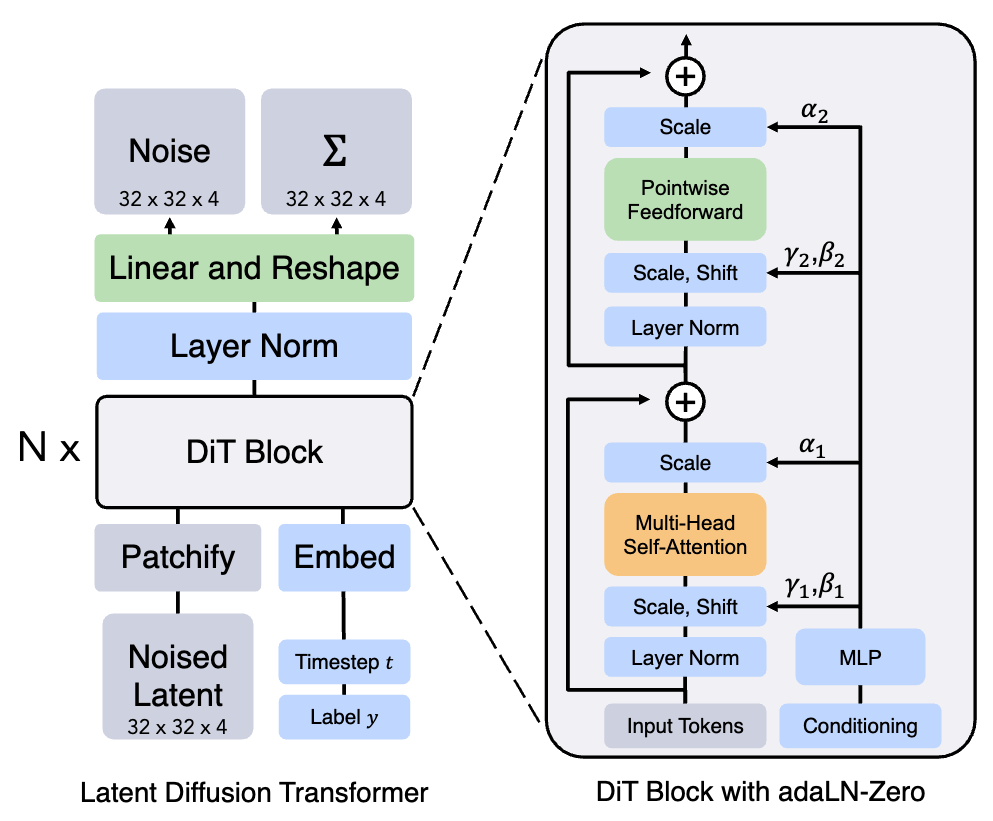
  <figcaption>DiT taken from paper.</figcaption>
</figure>


To speed things up, we’ve pre-implemented most of the model. Now it’s your turn to tackle the core DiT block.


#### Task: Implement the DiT Block

Implement the `DiTBlock` class’s `forward` method that:

- Takes inputs:

  - `x`: tensor of shape `(B, N, model_dim)` — the input features,
  - `c`: tensor of shape `(B, model_dim)` — conditioning vector.

- Performs the following steps:

  1. Pass `c` through `adaptive_norm_params` (a small MLP with SiLU + Linear) and split the output into six equal parts along the feature dimension:
     - `shift_msa`, `scale_msa`, `gate_msa`, `shift_mlp`, `scale_mlp`, `gate_mlp`.
  2. Apply adaptive layer norm modulation (`modulate`) to `x` before multi-head self-attention using `shift_msa` and `scale_msa`.
  3. Compute self-attention with query, key, and value all equal to the modulated `x`.
  4. Add the attention output to `x`, scaled by `gate_msa` (unsqueeze to broadcast).
  5. Apply adaptive layer norm modulation to `x` before the MLP using `shift_mlp` and `scale_mlp`.
  6. Pass the modulated tensor through the MLP.
  7. Add the MLP output to `x`, scaled by `gate_mlp`.

- Return the final tensor `x`.

You may use the helper function `modulate(x, shift, scale)` to apply the affine modulation.


In [ ]:
import torch.nn as nn
from typing import Any


class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """

    def __init__(
        self,
        model_dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        **block_kwargs: Any
    ) -> None:
        super().__init__()
        self.attn_norm = nn.LayerNorm(
            model_dim,
            elementwise_affine=False,
            eps=1e-6
        )
        self.attn = nn.MultiheadAttention(
            embed_dim=model_dim,
            num_heads=num_heads,
            bias=True,
            batch_first=True
        )
        self.mlp_norm = nn.LayerNorm(
            model_dim,
            elementwise_affine=False,
            eps=1e-6
        )
        mlp_hidden_dim = int(model_dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=model_dim,
            hidden_features=mlp_hidden_dim
        )
        self.adaptive_norm_params = nn.Sequential(
            nn.SiLU(),
            nn.Linear(model_dim, 6 * model_dim, bias=True)
        )

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        "YOUR CODE GOES HERE"
        raise NotImplementedError()

Finally, let's put everything together.


In [ ]:
class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """

    def __init__(
        self,
        input_size: int = 28,
        patch_size: int = 1,
        in_channels: int = 1,
        model_dim: int = 192,
        depth: int = 6,
        num_heads: int = 6,
        mlp_ratio: float = 4.0,
        class_dropout_prob: float = 0.2,
        num_classes: Optional[int] = 10,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.x_embedder = PatchEmbed(
            (input_size, input_size),
            patch_size,
            in_channels,
            model_dim,
        )
        self.t_embedder = TimestepEmbedder(model_dim)
        self.conditional = num_classes is not None and class_dropout_prob > 0
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches, model_dim),
            requires_grad=False
        )
        self.blocks = nn.ModuleList([
            DiTBlock(model_dim, num_heads, mlp_ratio=mlp_ratio)
            for _ in range(depth)
        ])
        self.final_layer = FinalLayer(
            model_dim,
            patch_size,
            self.out_channels
        )
        self.unpatchify = Unpatchify(
            num_patches=num_patches,
            patch_size=patch_size,
            out_channels=self.out_channels
        )
        self.initialize_pos_emb()

    def initialize_pos_emb(self):
        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(
            self.pos_embed.shape[-1],
            int(self.x_embedder.num_patches ** 0.5)
        )
        self.pos_embed.data.copy_(
            torch.from_numpy(pos_embed).float().unsqueeze(0)
        )

    def forward(
        self,
        x: torch.Tensor,                      # shape: (B, C, H, W)
        t: torch.Tensor,                      # shape: (B,)
        # returns shape: (B, out_channels, H, W)
    ) -> torch.Tensor:
        """
        Forward pass of DiT.

        Args:
            x: Input tensor of images or latent image representations, shape (B, C, H, W)
            t: Diffusion timestep tensor, shape (B,)

        Returns:
            Output tensor, shape (B, out_channels, H, W)
        """
        x = (
            self.x_embedder(x) +
            self.pos_embed
        )  # (B, N, D), where N = H * W / patch_size ** 2
        t = self.t_embedder(t)  # (B, D)
        for block in self.blocks:
            x = block(x, t)  # (B, N, D)
        x = self.final_layer(x, t)  # (B, N, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)      # (B, out_channels, H, W)
        return x


#################################################################################
#                                   DiT Configs                                 #
#################################################################################


def DiT_XS_2(**kwargs):
    return DiT(
        depth=6,
        model_dim=384,
        patch_size=2,
        num_heads=6,
        **kwargs
    )


def DiT_XS_4(**kwargs):
    return DiT(
        depth=6,
        model_dim=384,
        patch_size=4,
        num_heads=6,
        **kwargs
    )


MODEL_CONFIGS = {
    'DiT-XS/2': DiT_XS_2,
    'DiT-XS/4': DiT_XS_4
}

In [ ]:
patch_size = 4
model = MODEL_CONFIGS[f"DiT-XS/{patch_size}"](
    in_channels=1,
    input_size=28,
    num_classes=None
)

In [ ]:
test_dit_output_shape_matches_input()

In [ ]:
model.load_state_dict(
    torch.load(
        uncond_ckpt_path,
        weights_only=True,
        map_location=DEVICE
    )["ema_model_state_dict"]
)
model = model.to(DEVICE)
_ = model.eval()

### Unconditional Sampling


Let's sample using our method from the previous part.


In [ ]:
x, traj = sample_vp_sde_euler_maruyama_unconditional(
    model,
    num_samples=100,
    num_steps=1000,
    device=DEVICE
)
x = x.detach().cpu()
traj = traj.detach().cpu()

x.shape, traj.shape

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

grid = vutils.make_grid(
    x,
    nrow=10,
    padding=2,
    normalize=False
)
# Convert to numpy for plotting
npimg = grid.permute(1, 2, 0).cpu().numpy()  # convert (C, H, W) to (H, W, C)
# Plot
plt.figure(figsize=(3, 3))
plt.imshow(npimg, cmap='gray')
plt.axis('off')
plt.show()

Our images look nice, but we have no control on generation. Let's fix this.


### Guided Sampling with Classifier-Free Guidance


Suppose we want to **condition** generation on some label or feature $\mathbf{y}$. Ideally, we’d like to follow the **conditional score** $\nabla_{\mathbf{x}} \log p_t(\mathbf{x} \mid \mathbf{y})$.

By **Bayes’ theorem**,

$$
p_t(\mathbf{x}\mid \mathbf{y}) = \frac{p_t(\mathbf{y}\mid \mathbf{x})\, p_t(\mathbf{x})}{p_t(\mathbf{y})}.
$$

Taking the gradient w\.r.t. $\mathbf{x}$ gives:

$$
\nabla_{\mathbf{x}} \log p_t(\mathbf{x}\mid \mathbf{y}) = \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) + \nabla_{\mathbf{x}} \log p_t(\mathbf{y}\mid \mathbf{x}).
$$

So the conditional score is just the **unconditional score** plus a "classifier term", indicating how likely is the condition $\mathbf{y}$ given the data point $ \mathbf{x}$.

**Classifier-free guidance (CFG)** amplifies this conditional term with a weight $w\ge 0$. We define the **guided score**:

$$
\begin{aligned}
\nabla_{\mathbf{x}} \log p_t(\mathbf{x})_\text{guided}
&= \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) + w \big(\nabla_{\mathbf{x}} \log p_t(\mathbf{x}\mid \mathbf{y}) - \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) \big) \\
&= (1-w)\,\nabla_{\mathbf{x}} \log p_t(\mathbf{x}) + w\, \nabla_{\mathbf{x}} \log p_t(\mathbf{x}\mid \mathbf{y}).
\end{aligned}
$$

- $w=0$ → unconditional generation
- $w=1$ → standard conditional
- $w>1$ → stronger push toward $\mathbf{y}$

Finally, to apply CFG to a **reverse-time SDE**, we plug the guided score directly into the drift term:

$$
\mathrm{d}\mathbf{x} = \Big[-\frac12 \beta(t)\mathbf{x} - \beta(t) \big( (1-w)\,\nabla_{\mathbf{x}} \log p_t(\mathbf{x}) + w\, \nabla_{\mathbf{x}} \log p_t(\mathbf{x}\mid \mathbf{y}) \big) \Big] \mathrm{d}t + \sqrt{\beta(t)}\,\mathrm{d}\bar{\mathbf{w}}.
$$

And that’s it! We now have a **conditionally-guided reverse process**, derived in a principled way using Bayes.

How we train for CFG?

1. During training, **randomly drop the conditioning** $\mathbf{y}$ with some probability (e.g., 10–20%).
2. When $\mathbf{y}$ is dropped, the model learns the **unconditional score** $\nabla_{\mathbf{x}} \log p_t(\mathbf{x})$.
3. When $\mathbf{y}$ is provided, the model learns the **conditional score** $\nabla_{\mathbf{x}} \log p_t(\mathbf{x}\mid \mathbf{y})$.

At sampling time, we can then interpolate or amplify the conditional signal using the guided score formula. This **simple trick allows a single model to flexibly do CFG** without needing two models, the unconditional and conditional one.


To save time, we have already trained a version of DiT that supports classifier-free guidance. Your task is to extend this model by:

1. **Implementing the `LabelEmbedder`** – a module that takes a target class and projects it into a hidden representation for the model.
2. **Integrating the label information** – carefully inject this embedding into the model’s processing flow.


#### Task: Implement LabelEmbedder

Complete the `forward` method of the `LabelEmbedder` class as follows:

- If `dropout_prob > 0` **and** `should_drop` is `True`, apply label dropout by calling `self.token_drop(labels)`. This randomly replaces some class labels with a special classifier-free guidance token.
- Otherwise, use the original `labels` as is.
- Pass the resulting labels through the embedding layer `self.embedding` and return the embeddings.

**Inputs:**

- `labels`: Tensor of shape $(B,)$ containing class indices.
- `should_drop`: Boolean flag indicating whether to apply label dropout (usually `True` during training).

**Output:**

- Tensor of shape $(B, \texttt{model\_dim})$ containing label embeddings.

---

**Hint:** Use `self.token_drop()` for dropout and `self.embedding` for the embedding lookup.


In [ ]:
class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """

    def __init__(self, num_classes: int, model_dim: int, dropout_prob: float) -> None:
        super().__init__()
        use_cfg_embedding: bool = dropout_prob > 0
        self.embedding = nn.Embedding(
            num_classes + int(use_cfg_embedding),
            model_dim
        )
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels: torch.Tensor) -> torch.Tensor:
        """
        Drops labels to enable classifier-free guidance.

        :param labels: torch.Tensor of shape (B,) containing class indices.
        :return: torch.Tensor of shape (B,) with some labels possibly replaced with cfg token.
        """
        batch_size, *_ = labels.shape
        drop_ids = (
            torch.rand(
                batch_size,
                device=labels.device
            ) < self.dropout_prob
        )
        return torch.where(
            drop_ids,
            torch.full_like(
                labels,
                fill_value=self.num_classes
            ),
            labels
        )

    def forward(self, labels: torch.Tensor, should_drop: bool) -> torch.Tensor:
        """
        :param labels: torch.Tensor of shape (B,) containing class indices.
        :param should_drop: Whether to apply label dropout (usually True during training).
        :return: torch.Tensor of shape (B, model_dim) containing label embeddings.
        """
        "YOUR CODE GOES HERE"
        raise NotImplementedError()

#### Task: Extend `DiT` to Support Classifier-Free Guidance (CFG)

Complete the `forward` method of the `DiT` class to enable conditional sampling with CFG:

- Embed the input image `x` using `self.x_embedder` and add positional embeddings `self.pos_embed`.
- Embed the timestep tensor `t` using `self.t_embedder`.
- If the model is conditional (`self.conditional` is True):
  - Embed the class labels `y` using `self.y_embedder`, applying class dropout when `apply_class_dropout` is True.
- Otherwise, create a zero tensor matching the timestep embedding shape.
- Combine the timestep embedding `t` and the class embedding (or zeros) by addition to get conditioning vector `c`.
- Pass `x` and `c` through each transformer block (`self.blocks`).
- Pass the result through the final layer and unpatchify to reconstruct the output image.
- Return the output tensor.

**Inputs:**

- `x`: Input tensor of shape `(B, C, H, W)`
- `t`: Timestep tensor of shape `(B,)`
- `y`: Class label tensor of shape `(B,)`
- `apply_class_dropout`: Boolean flag to apply label dropout (used during training for CFG)

**Output:**

- Tensor of shape `(B, out_channels, H, W)` — predicted noise or denoised image

**Hint:** Use `self.y_embedder(y, apply_class_dropout)` only if conditional; else use zeros of shape `(B, model_dim)`.

Your implementation should match the provided interface and support CFG during training and sampling.


In [ ]:
class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """

    def __init__(
        self,
        input_size: int = 28,
        patch_size: int = 1,
        in_channels: int = 1,
        model_dim: int = 192,
        depth: int = 6,
        num_heads: int = 6,
        mlp_ratio: float = 4.0,
        class_dropout_prob: float = 0.2,
        num_classes: Optional[int] = 10,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.x_embedder = PatchEmbed(
            (input_size, input_size),
            patch_size,
            in_channels,
            model_dim,
        )
        self.t_embedder = TimestepEmbedder(model_dim)
        self.conditional = num_classes is not None and class_dropout_prob > 0

        "ADD REQUIRED MODULE HERE"
        raise NotImplementedError()

        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches, model_dim),
            requires_grad=False
        )
        self.blocks = nn.ModuleList([
            DiTBlock(model_dim, num_heads, mlp_ratio=mlp_ratio)
            for _ in range(depth)
        ])
        self.final_layer = FinalLayer(
            model_dim,
            patch_size,
            self.out_channels
        )
        self.unpatchify = Unpatchify(
            num_patches=num_patches,
            patch_size=patch_size,
            out_channels=self.out_channels
        )
        self.initialize_pos_emb()

    def initialize_pos_emb(self):
        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(
            self.pos_embed.shape[-1],
            int(self.x_embedder.num_patches ** 0.5)
        )
        self.pos_embed.data.copy_(
            torch.from_numpy(pos_embed).float().unsqueeze(0)
        )

    def forward(
        self,
        x: torch.Tensor,                      # shape: (B, C, H, W)
        t: torch.Tensor,                      # shape: (B,)
        y: torch.Tensor,                      # shape: (B,)
        apply_class_dropout: bool = False
        # returns shape: (B, out_channels, H, W)
    ) -> torch.Tensor:
        """
        Forward pass of DiT.

        Args:
            x: Input tensor of images or latent image representations, shape (B, C, H, W)
            t: Diffusion timestep tensor, shape (B,)
            y: Class label tensor, shape (B,)
            apply_class_dropout: Whether to apply class dropout

        Returns:
            Output tensor, shape (B, out_channels, H, W)
        """
        x = (
            self.x_embedder(x) +
            self.pos_embed
        )  # (B, N, D), where N = H * W / patch_size ** 2
        t = self.t_embedder(t)  # (B, D)

        "IMPLEMENT CONDITIONING ON LABEL HERE"
        raise NotImplementedError()

        c = t + y  # (B, D)
        for block in self.blocks:
            x = block(x, c)  # (B, N, D)
        x = self.final_layer(x, c)  # (B, N, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)      # (B, out_channels, H, W)
        return x


#################################################################################
#                                   DiT Configs                                 #
#################################################################################


def DiT_XS_2(**kwargs):
    return DiT(
        depth=6,
        model_dim=384,
        patch_size=2,
        num_heads=6,
        **kwargs
    )


def DiT_XS_4(**kwargs):
    return DiT(
        depth=6,
        model_dim=384,
        patch_size=4,
        num_heads=6,
        **kwargs
    )


MODEL_CONFIGS = {
    'DiT-XS/2': DiT_XS_2,
    'DiT-XS/4': DiT_XS_4
}

#### Task: Solving Reverse SDE with Classifier-Free Guidance


Recall that our (conditional) **reverse-time SDE** is :

$$
\mathrm{d}\mathbf{x} = \Big[-\frac12 \beta(t)\mathbf{x} - \beta(t) \big( (1-w)\,\nabla_{\mathbf{x}} \log s_\theta(x,t,\emptyset) + w\, \nabla_{\mathbf{x}} s_\theta(x,t,y)  \big) \Big] \mathrm{d}t + \sqrt{\beta(t)}\,\mathrm{d}\bar{\mathbf{w}}.
$$

where:

- $x$ is the system state at time $t$, flowing **backwards from $T=1$ down to $\epsilon=1\text{e-5}$**. We **stop at $\epsilon$ instead of 0 for numerical stability**.
- $\beta(t)$ is the variance schedule function.
- $s_\theta(x,t, ∅)$ is the unconditional score function estimate.
- $s_\theta(x,t, y)$ is the conditional score function estimate.
- $d\bar{w}$ is standard Brownian motion in reverse time.
- $w \in [0, ∞)$ is the guidance weighting factor.

We will discretize this reverse SDE using Euler-Maryama method.

For a backward step from $t$ to $t-\Delta t$ ($\Delta t > 0$):

$$
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t - \Bigg[
-\frac12 \beta(t)\mathbf{x}_t
- \beta(t) \Big( (1-w)\, \nabla_{\mathbf{x}} \log s_\theta(\mathbf{x}_t,t,\emptyset) + w\, \nabla_{\mathbf{x}} s_\theta(\mathbf{x}_t,t,y) \Big)
\Bigg] \Delta t + \sqrt{\beta(t)\, \Delta t}\, \mathbf{z}
$$

where:

- $\mathbf{x}_t$ is the current state.
- $\mathbf{x}_{t-\Delta t}$ is the state at the next (earlier) time step.
- $\Delta t = t_i - t_{i+1} > 0$ is the time step.


**Your task:**

Implement a PyTorch function `sample_vp_sde_euler_maruyama` that:

1. **Inputs:**

   - `model: ScoreModel` – a PyTorch module that takes `(x, t)` and returns the **scaled score** $\sigma^2(t) s_\theta(x,t)$.
   - `num_samples: int` – number of samples to generate.
   - `sample_shape: List[int]` – shape of a single sample (default `[2]`).
   - `T: float` – starting time (default `1.0`).
   - `num_steps: int` – number of discrete steps for Euler-Maruyama (default `1000`).
   - `eps: float` – final time for numerical stability (default `1e-5`).
   - `device: str` – device for computation (CPU or GPU).
   - `guidance_scale: float` – CFG weight.
   - `label: int` - desired label (digit) to sample.

2. **Outputs:**

   - `x_T: torch.Tensor` – final state at $t \approx \epsilon$, shape `[num_samples] + sample_shape`.
   - `trajectory: torch.Tensor` – the full trajectory of all samples, shape `[num_samples, num_steps+1, *sample_shape]`.

**Hint:**

- Use `torch.full` to create a time tensor for the batch and `torch.randn_like` for the Brownian noise.
- Remember to **divide the model output by $\sigma^2(t)$** to obtain the true score.


In [ ]:
from typing import Tuple
from einops import rearrange
import torch


@torch.inference_mode()
def sample_vp_sde_euler_maruyama(
    model,
    num_samples,
    T=1.0,
    num_steps=1000,
    eps=1e-5,
    device="cpu",
    guidance_scale: float = 1.0,
    label: int = 0
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    VP-SDE Euler-Maruyama sampler with classifier-free guidance.
    """
    # Create time steps from T down to eps
    t_steps = torch.linspace(T, eps, num_steps + 1, device=device)
    # Start with random noise
    x = torch.randn((num_samples, 1, 28, 28), device=device)
    trajectory = [x.clone()]
    # Target label
    y_target = (
        label * torch.ones((num_samples, ), device=device)
    ).long()
    # Empty label
    y_empty = (
        model.y_embedder.num_classes *
        torch.ones((num_samples, ), device=device)
    ).long()
    for i in range(num_steps):
        t = t_steps[i]
        dt = t_steps[i] - t_steps[i + 1]
        dw = torch.randn_like(x)
        t_batch = torch.full((num_samples,), t, device=device)  # type: ignore
        # Beta and sigma schedule
        beta_t = beta(t)
        sigma_t = sigma(t)

        "IMPLEMENT CLASSIFIER FREE GUIDANCE HERE"
        raise NotImplementedError()

        # Drift & diffusion
        drift = -0.5 * beta_t * x - beta_t * score
        diffusion = torch.sqrt(beta_t)
        # Euler-Maruyama update
        x = x - drift * dt + diffusion * torch.sqrt(dt) * dw
        trajectory.append(x.clone())

    trajectory = rearrange(
        torch.stack(trajectory, dim=0),
        "t b c h w -> b t c h w"
    )

    return trajectory[:, -1, ...], trajectory

In [ ]:
model = MODEL_CONFIGS[f"DiT-XS/{patch_size}"](
    in_channels=1,
    input_size=28,
    num_classes=10
)

model.load_state_dict(
    torch.load(
        cond_ckpt_path,
        weights_only=True,
        map_location=DEVICE
    )["ema_model_state_dict"]
)
model = model.to(DEVICE)
_ = model.eval()

In [ ]:
num_samples = 5
num_digits = 10
num_steps = 500
guidance_scales = [0, 1, 2, 4, 6]

Let's generate a few samples for each digit at each guidance scale. The process takes approximately 5 minutes. If you don’t have access to a GPU, consider reducing the number of steps and/or the number of guidance scales.


In [ ]:
samples_per_guidance_scale = []

for guidance_scale in guidance_scales:
    samples = []
    for label in tqdm(range(0, num_digits)):
        x, traj = sample_vp_sde_euler_maruyama(
            model,
            num_samples=num_samples,
            num_steps=num_steps,
            device=DEVICE,
            guidance_scale=guidance_scale,
            label=label
        )
        samples.append(x)

    samples_per_guidance_scale.append(torch.stack(samples))

Visualize samples.


In [ ]:
plotted_samples = [
    plot_samples_with_title(
        samples,
        guidance_scale,
        list(range(num_digits)),
        num_digits,
        nrow=num_samples,
        show_labels=(i == 0)
    )
    for i, (samples, guidance_scale) in enumerate(zip(samples_per_guidance_scale, guidance_scales))
]

divider_width = 1
divider_color = (255, 255, 255)
total_width = (
    sum(img.width for img in plotted_samples) +
    divider_width * (len(plotted_samples) - 1)
)
max_height = max(img.height for img in plotted_samples)

plot = Image.new("RGB", (total_width, max_height), color=(0, 0, 0))
x_offset = 0
for i, img in enumerate(plotted_samples):
    plot.paste(img, (x_offset, 0))
    x_offset += img.width
    if i < len(plotted_samples) - 1:
        divider = Image.new(
            "RGB",
            (divider_width, max_height),
            color=divider_color
        )
        plot.paste(divider, (x_offset, 0))
        x_offset += divider_width

plot

How do samples behave as the guidance scale varies?
